# 06_Introduction_to_convnets

컨브넷 정의와 컨브넷이 컴퓨터 비전 관련 작업에 잘 맞는 이유에 대해 이론적 배경을 알아봅시다. 예제를 통해 알아보면 이해하기 쉽습니다. fully connected network(완전연결네트워크)로 풀었던(이 방식의 테스트 정확도는 약 97.8%였습니다) MNIST 숫자 이미지 분류에 컨브넷을 사용해 보겠습니다. 기본적인 컨브넷이더라도 완전 연결된 모델의 성능을 훨씬 앞지를 것입니다.  

## Setup

In [4]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()  

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
import warnings
warnings.filterwarnings("ignore")

In [16]:
from tensorflow.keras import layers

In [27]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))

<br>

컨브넷이 **(image_height, image_width, image_channels)**크기의 입력 텐서를 사용한다는 점이 중요합니다(배치 차원은 포함하지 않습니다). 이 예제에서는 MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하도록 컨브넷을 설정해야 합니다. 이 때문에 첫번째 층의 매개변수로 `input_shape=(28, 28, 1)`을 전달했습니다.

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


<br>

**Conv2D**와 **MaxPooling2D**층의 출력은 (height, width, channels)크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 작아지는 경향이 있습니다. 채널의 수는 Conv2D 층에 전달된 첫 번째 매개변수에 의해 조절됩니다(32 혹은 64개).  

다음 단계에서 마지작층의 ((3, 3, 64) 크기인) 출력 텐서를 완전 연결 네트워크에 주입합니다. 이 분류기는 1D 벡터를 처리하는데, 이전 층의 출력이 3D 텐서입니다. 그래서 먼저 3D 출력을 1D텐서로 펼쳐야 합니다.

In [29]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
__________

<br>

여기에서 볼 수 있듯이 (3, 3, 64) 출력이 (576, )크기의 벡터로 펼쳐진 후 Dense 층으로 주입되었습니다.  

이제 MNIST 숫자 이미지에 이 컨브넷을 훈련합니다.

In [30]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [31]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32")/255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32")/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [32]:
from tensorflow.keras import optimizers, metrics, losses

In [33]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss=losses.categorical_crossentropy, metrics=[metrics.categorical_accuracy])

In [34]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
#         print('\repoch {}'.format(epoch, end=""))
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\thistory key: {}".format(list(logs.keys())))
        print("\repoch: {}, loss: {}".format(epoch+1, logs["loss"]), end=" ")

        if (epoch+1) % 5 == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("acc: {:.5f}".format(logs["categorical_accuracy"]), end="\n")
#             print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
#             print("val_acc: {:.5f}".format(logs["val_binary_accuracy"]))

In [35]:
n_epochs = 30

In [36]:
history = model.fit(train_images, train_labels, 
                    epochs=n_epochs, batch_size=64, 
                    verbose=0, callbacks=[LossAndErrorPrintingCallback(n_epochs)])

epoch: 1, loss 0.02113 	history key: ['loss', 'categorical_accuracy']
Epoch 5/30 loss: 0.02370 acc: 0.99230
Epoch 10/30 loss: 0.01086 acc: 0.99645
Epoch 15/30 loss: 0.00522 acc: 0.99833
Epoch 20/30 loss: 0.00289 acc: 0.99907
Epoch 25/30 loss: 0.00393 acc: 0.99877
Epoch 30/30 loss: 0.00352 acc: 0.99903


In [37]:
history_dict = history.history

In [38]:
import matplotlib.pyplot as plt

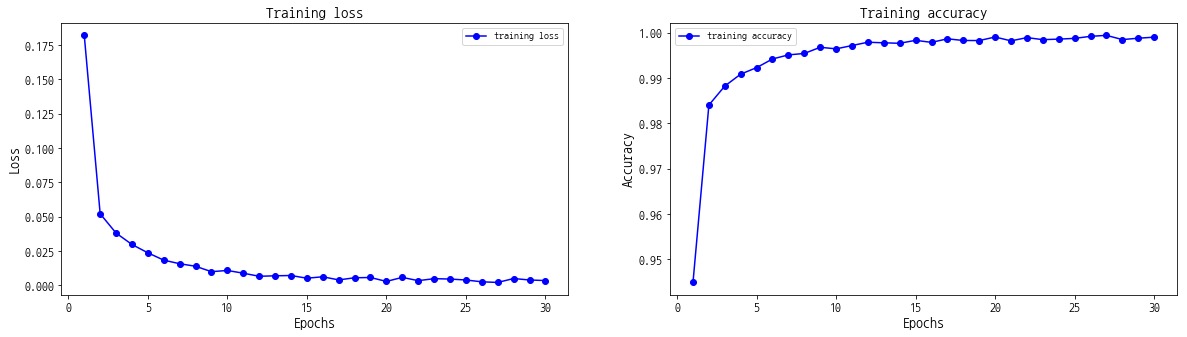

In [39]:
loss = history_dict["loss"]
acc = history_dict["categorical_accuracy"]

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(epochs, loss, "bo-", label="training loss")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, "bo-", label="training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()

plt.show()

In [40]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 4s 388us/sample - loss: 0.0575 - categorical_accuracy: 0.9915


In [41]:
test_acc

0.9915

<br>

완전 연결 네트워크는 97.8%의 테스트 정확도를 얻은 반면에 기본적인 컨브넷은 99.15%의 테스트 정확도를 얻었습니다.

<br>

## 6.1 The convolution operation

완전 연결층과 합성곱 층 사이의 근본적인 차이는 다음과 같습니다. Dense 층인 입력 특성 공간에 있는 전역 패턴(예를 들어 MNIST 숫자 이미지에서는 모든 픽셀에 걸친 패턴)을 학습하지만 합성곱 층은 지역 패턴을 학습합니다(아래그림 참조). 이미지일 경우 작은 2D window로 입력에서 패턴을 찾습니다. 앞의 예에서 이 윈도우는 모두 3X3크기 였습니다.

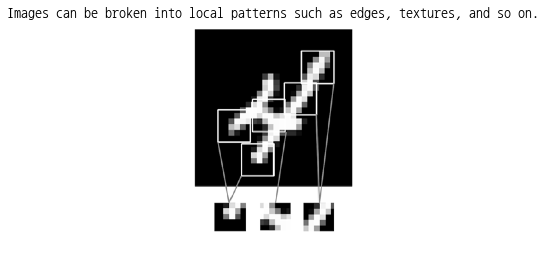

In [46]:
plt.figure(figsize=(10, 4))
plt.title("Images can be broken into local patterns such as edges, textures, and so on.", fontsize=14)
plot_external2("./images/ch06/1.png")
plt.show()

이 핵심 특징은 컨브넷에 두 가지 흥미로운 성질을 제공합니다.  

- 학습된 패턴은 평행 이동 불변성(translation invariant)을 가집니다. 컨브넷이 이미지의 오른쪽 아래 모서리에서 어떤 패턴을 학습했다면 다른 곳(왼쪽 위 모서리 등)에서도 이 패턴을 인식할 수 있습니다. 완전 연결 네트워크는 새로운 위치에 나타난 것은 새로운 패턴으로 학습해야 합니다. 이런 성질은 컨브넷이 이미지를 효율적으로 처리하게 만들어 줍니다(근본적으로 우리가 보는 세상은 평행 이동으로 인해 다르게 인식되지 않습니다). 적은 수의 훈련 샘플을 사용해서 일반화 능력을 가진 표현을 학습할 수 있습니다.  

- 컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있습니다(아래 그림 참고). 첫 번째 합성곱 층이 엣지 같은 작은 지역 패턴을 학습합니다. 두번째 합성곱 층은 첫번째 층의 특성으로 구성된 더 큰 패턴을 학습하는 식입니다. 이런 방식을 사용하여 컨브넷은 매우 복잡하고 추상적인 시각적 개념을 효과적으로 학습할 수 있습니다(근본적으로 우리가 보는 세상은 공간적 계층 구조를 가집니다).

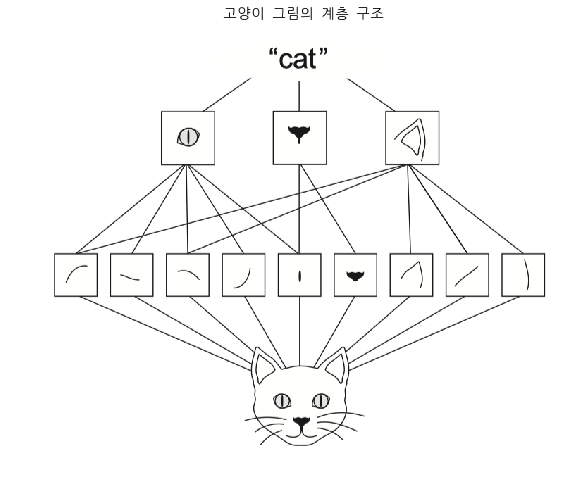

In [52]:
plt.figure(figsize=(12, 8))
plt.title("고양이 그림의 계층 구조", fontsize=14)
plot_external2("./images/ch06/2.png")
plt.show()

합성곱 연산은 특성 맵(feature map)이라고 부르는 3D 텐서에 적용됩니다. 이 텐서는 2개의 공간 축(높이와 너비)과 깊이 축(채널 축이라고도 합니다)으로 구성됩니다. RGB 이미지는 3개의 컬러 채널(빨간색, 녹색, 파란색)을 가지므로 깊이 축의 차원이 3이 됩니다. MNIST 숫자처럼 흑백 이미지는 깊이 축의 차원이 1(회색톤)입니다. 합성공 연산은 입력 특성 맵에서 작은 패치(patch)들을 추출하고 이런 모든 패치에 같은 변환을 적용하여 출력 특성 맵(output feature map)을 만듭니다.  

출력 특성 맵도 높이와 너비를 가진 3D 텐서입니다. 출력 텐서의 깊이는 층의 매개변수로 결정되기 때문에 상황에 따라 다릅니다. 이렇게 되면 깊이 축의 채널은 더 이상 RGB입력처럼 특정 컬러를 의미하지 않습니다. 그 대신 일종의 필터(filter)를 의미합니다. 필터는 입력 데이터의 어떤 특성을 인코딩합니다. 예를 들어 고수준으로 보면 하나의 필터가 "입력에 얼굴이 있는지"를 인코딩할 수 있습니다.  

MNIST 예제에서는 첫 번째 합성곱 층이 (28, 28, 1) 크기의 특성 맵을 입력으로 받아 (26, 26, 32) 크기의 특성 맵을 출력합니다. 즉 입력에 대해 32개의 필터를 적용합니다. 32개의 출력 채널은 각각은 26X26 크기의 배열 값을 가집니다. 이 값은 입력에 대한 필터의 응답 맵(response map)입니다. 입력의 각 위치에서 필터 패턴에 대한 응답을 나타냅니다(아래그림 참고). 특성 맵이란 말이 의미하는 것은 다음과 같습니다. 깊이 축에 있는 각 차원은 하나의 특성(또는 필터)이고, 2D 텐서 output[:, :, n]은 입력에 대한 이 필터 응답을 나타내는 2D 공간상의 맵입니다. 

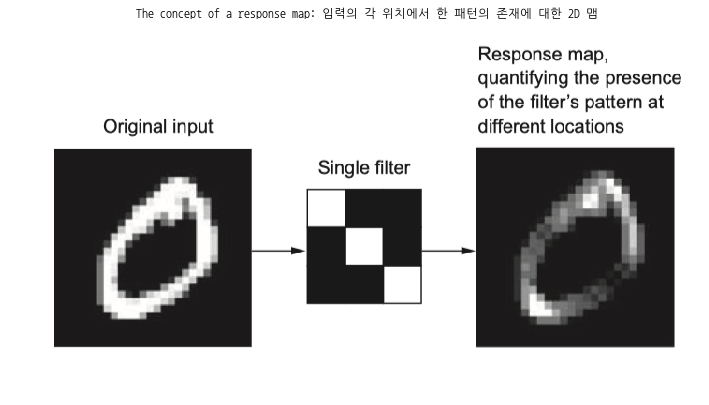

In [57]:
plt.figure(figsize=(12, 8))
plt.title("The concept of a response map: 입력의 각 위치에서 한 패턴의 존재에 대한 2D 맵", fontsize=12)
plot_external2("./images/ch06/3.png")
plt.show()

<br>

합성곱은 핵심적인 2개의 파라미터로 정의됩니다.  

- 입력으로부터 뽑아낼 패치의 크기: 전형적으로 3X3 또는 5X5크기를 사용합니다.  
- 특성맵의 출력 깊이: 합성곱으로 계산할 필터의 수입니다.  

케라스의 Conv2D 층에서 이 파라미터는 

```python
Conv2D(output_depth, (window_height, window_width))
```

처럼 첫 번째와 두번째 매개변수로 전달됩니다.  

3D 입력 특성 맵 위를 3X3 또는 5X5 크기의 윈도우가 슬라이딩(sliding)하면서 모든 위치에서 3D 특성 패치((window_height, window_width, input_depth) 크기)를 추출하는 방식으로 합성곱이 작동합니다. 이런 3D 패치는 (output_depth, )크기의 1D 벡터로 변환됩니다. 합성공 커널(convolution kernel)이라고 불리는 하나이 학습된 가중치 행렬과의 텐서 곱셈을 통하여 변환됩니다. 합성곱 커널은 합성곱 층의 필터를 하나의 행렬로 합친 것을 말합니다. 첫 번째 합성곱 층의 커널 크기는 (3, 3, 1, 32)이고, 2번재 합성곱 층의 커널 크기는 (3, 3, 32, 64) 입니다. 변환된 모든 벡터는 (height, width, output_depth) 크기의 3D 특성 맵으로 재구성됩니다. 출력 특성 맵의 공간상 위치는 입력 특성 맵의 같은 위치에 대응됩니다(예를 들어 출력의 오른쪽 아래 모서리는 입력의 오른쪽 아래 부근에 해당하는 정보를 답고 있습니다). 3X3 윈도우를 사용하면 3D 패치 **input[i-1:i+2, j-1:j+2, :]**로부터 벡터 **output[i, j, :]**가 만들어집니다. 이 과정은 아래 그림과 같습니다.

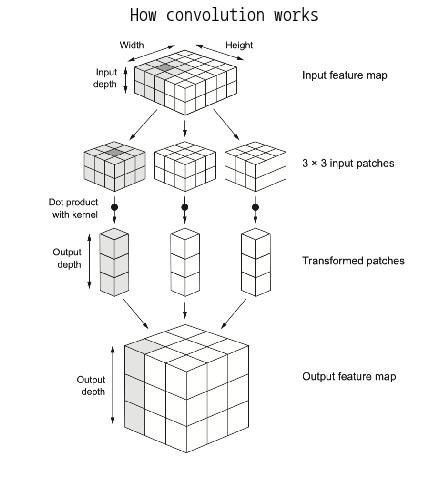

In [59]:
plt.figure(figsize=(12, 8))
plt.title("How convolution works", fontsize=18)
plot_external2("./images/ch06/4.png")
plt.show()

<br>

출력 높이와 너비는 입력의 높이, 너비와 다를 수 있습니다. 여기에는 2가지 이유가 있습니다.  

- 경계 문제: 입력 특성맵에 패딩을 추가하여 대응할 수 있습니다.  
- 스트라이드(stride)의 사용 여부에 따라 다릅니다.

<br>

### 6.1.1 Understanding Border Effects And Padding

5X5 크기의 특성맵을 생각해보겠습니다(총 25개의 타일이 있다고 생각합니다). 3X3크기인 윈도우의 중앙을 맞출 수 있는 타일은 3X3 격자를 형성하는 9개뿐입니다(아래 그림). 따라서 출력 특성 맵은 3X3 크기가 됩니다. 크기가 조금 줄어들었습니다. 여기에서는 높이와 너비 차원을 따라 정확히 2개의 타일이 줄어들었습니다. 

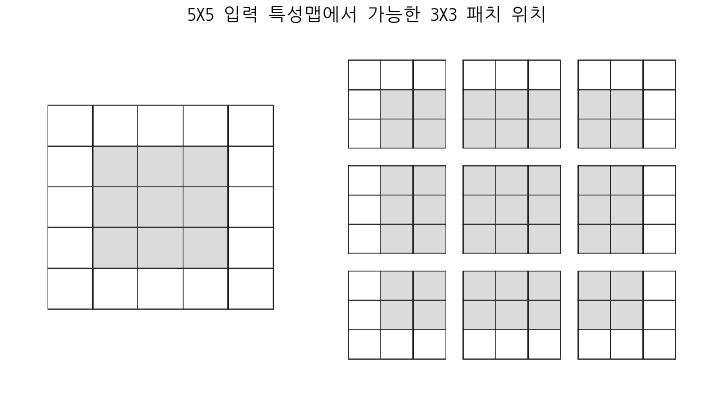

In [67]:
plt.figure(figsize=(12, 8))
plt.title("5X5 입력 특성맵에서 가능한 3X3 패치 위치", fontsize=18)
plot_external2("./images/ch06/5.png")
plt.show()

<br>

앞 선예에서도 첫 번째 합성곱 층에서 28X28크기의 입력이 26X26으로 줄어들은 것을 볼 수 있습니다(아래 그림 참조).

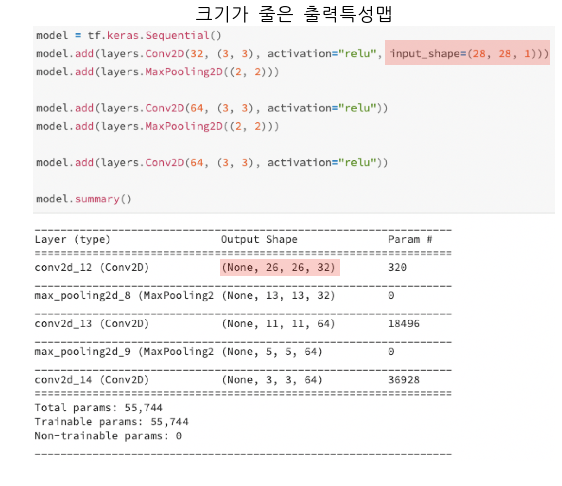

In [71]:
plt.figure(figsize=(12, 8))
plt.title("크기가 줄은 출력특성맵", fontsize=18)
plot_external2("./images/ch06/8.png")
plt.show()

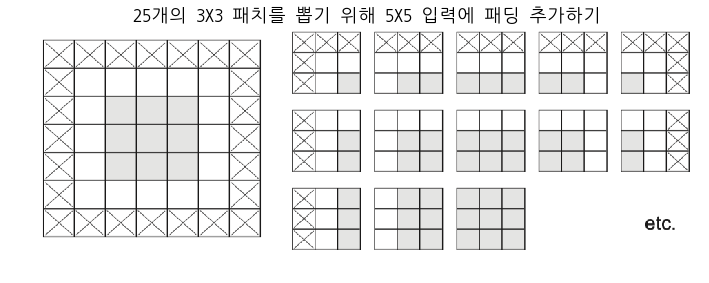

In [64]:
plt.figure(figsize=(12, 8))
plt.title("25개의 3X3 패치를 뽑기 위해 5X5 입력에 패딩 추가하기", fontsize=18)
plot_external2("./images/ch06/6.png")
plt.show()

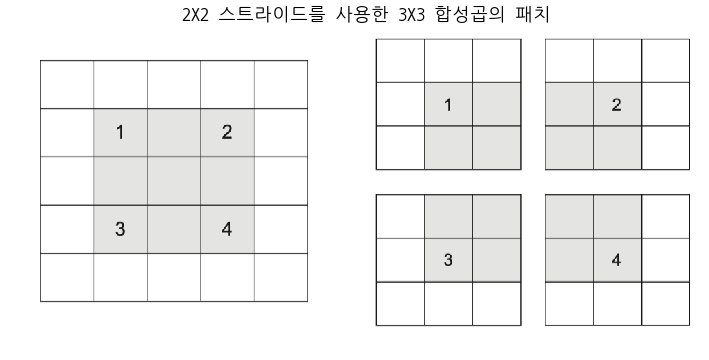

In [66]:
plt.figure(figsize=(12, 8))
plt.title("2X2 스트라이드를 사용한 3X3 합성곱의 패치", fontsize=18)
plot_external2("./images/ch06/7.png")
plt.show()

In [ ]:
6.1.1 Understanding Border Effects And Padding

In [70]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________
